In [2]:
import copy
import os
import pickle as pkl
import sys
import dataclasses

import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy as sp
from fusiondls import MagneticGeometry, SimulationInputs, file_read, file_write, run_dls
from fusiondls.analytic_cooling_curves import LfuncKallenbach
# from fusiondls.Profile import Profile
from fusiondls.unpackConfigurationsMK import unpackConfigurationMK
from netCDF4 import Dataset
from scipy import interpolate

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from code_comparison.solps_pp import *
from sdtools.general.plotstyle import change_colors

from DLS.postprocess import *

change_colors("default")

%matplotlib inline

%load_ext autoreload
%autoreload 2


# Read SOLPS case

In [3]:
balance_paths = {
    "100MW_inner_arpuff" : r"C:\Users\Mike\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed\step0_A5e21D1e24spr",
    "100MW_innerar_midplanepuff" : r"C:\Users\Mike\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed_impomp_puff\step2_Xomp20_A8e21D0p4e24sp50r",
}

store_slc = {}

for case in balance_paths:
    print(case)
    if "balance.nc" in os.listdir(balance_paths[case]):
        store_slc[case] = SOLPScase(balance_paths[case])
        store_slc[case].get_species()
        store_slc[case].get_impurity_stats("Ar", all_states = True)
    else:
        print(f"Skipping {case} as no balance.nc file found")

100MW_inner_arpuff
Saving all states
Added total radiation, density and fraction for Ar
100MW_innerar_midplanepuff
Saving all states
Added total radiation, density and fraction for Ar


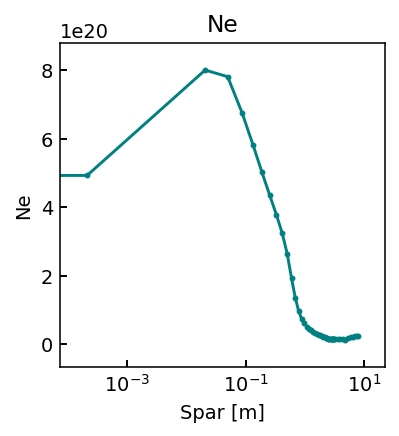

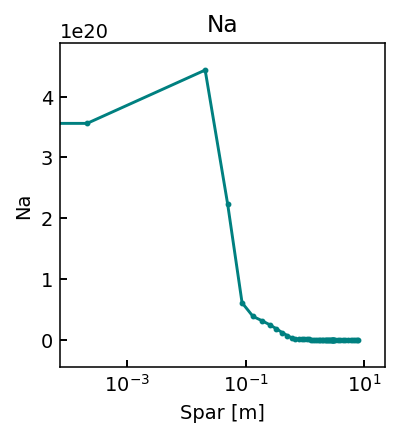

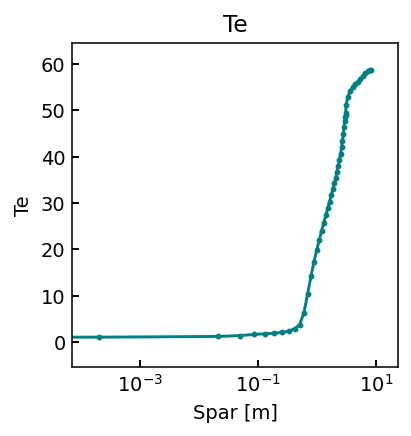

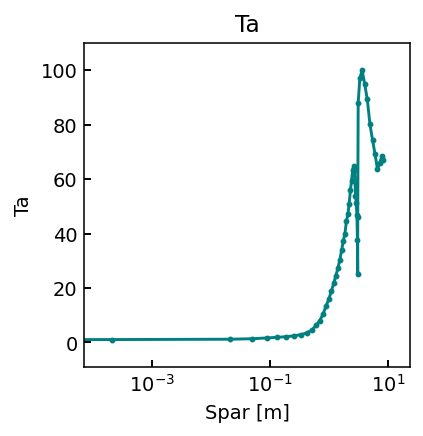

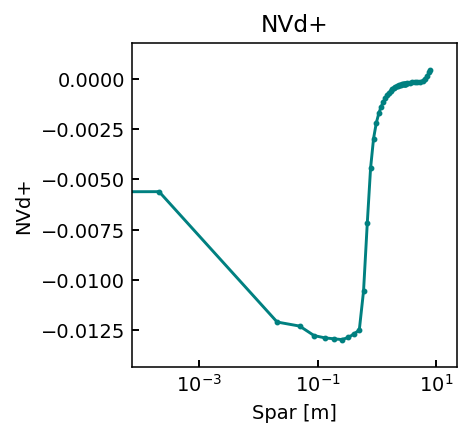

In [20]:
slc = store_slc["100MW_inner_arpuff"]
df = slc.get_1d_poloidal_data(["Ne", "Na", "Te", "Ta", "NVd+"], sepadd = 5)


for param in ["Ne", "Na", "Te", "Ta", "NVd+"]:
    
    fig, ax = plt.subplots(figsize = (3,3))
    
    x = df["Spol"].max() - df["Spol"]
    ax.plot(x, df[param], marker = "o", ms = 2)
    ax.set_xscale("log")
    ax.set_xlabel("Spar [m]")
    ax.set_ylabel(param)
    ax.set_title(param)

# Calculate field lines

In [6]:
dfs = {}
sepadds = 6

for case in ["100MW_inner_arpuff", "100MW_innerar_midplanepuff"]:
    dfs[case] = {}
    for region in ["outer_lower", "inner_lower", "outer_upper", "inner_upper"]:
        dfs[case][region] = {}
        
        for i in range(sepadds):
            df = store_slc[case].get_1d_poloidal_data(["RAr","M", "Pe", "Te", "Ne", "fAr", "Btot", "R", "fhx_total", "fhex_cond", "Sd+_iz", "vol"], sepadd = i, region = region, target_first = True)   
            cumR = sp.integrate.cumulative_trapezoid(y = df["RAr"] / df["Btot"], x = df["Spar"], initial = 0)    
            df["cumR"] = cumR/cumR[-1]
            df["hf_tot"] = df["fhx_total"] / df["apar"] * -1
            df["hf_cond_e"] = df["fhex_cond"] / df["apar"] * -1
            
            dfs[case][region][i] = df

colors = [plt.cm.get_cmap("rainbow", sepadds)(x) for x in range(sepadds)]
line_style = dict(lw = 0.75, marker = "o", ms = 1.5)
xpoint_style = dict(marker = "x", ms = 7)

C:\Users\Mike\AppData\Local\Temp\ipykernel_14572\3006447686.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [plt.cm.get_cmap("rainbow", sepadds)(x) for x in range(sepadds)]


In [44]:
case = '100MW_inner_arpuff'
# case = '100MW_innerar_midplanepuff'
# region = "outer_upper"
region = "inner_upper"
results = {}


for side in ["inner", "outer"]:
    df_out = pd.DataFrame()
    sepadd = 0
    
    for sepadd in range(sepadds):

        df = dfs[case][f"{side}_lower"][sepadd]
        df_out.loc[sepadd, "qmax"] = df["hf_tot"].max()
        df_out.loc[sepadd, "Beff"] = np.sqrt(  # Radiation weighted average B field (term alpha in Kryjak 2025)
                        sp.integrate.trapezoid(y=df["hf_tot"] * df["R"], x=df["Spar"])
                        / sp.integrate.trapezoid(
                            y=df["hf_tot"] * df["R"] / df["Btot"] ** 2, x=df["Spar"]
                        )
                    )
        df_out.loc[sepadd, "Bt"] = df["Btot"][0]
        df_out.loc[sepadd, "Bx"] = df[df["Xpoint"]==True]["Btot"].values[0]

        df_out.loc[sepadd, "fR"] = df_out.loc[sepadd, "Bx"] / df_out.loc[sepadd, "Bt"]
        df_out.loc[sepadd, "fR_eff"] = df_out.loc[sepadd, "Bx"] / df_out.loc[sepadd, "Beff"]
    
    results[side] = df_out.copy()
    

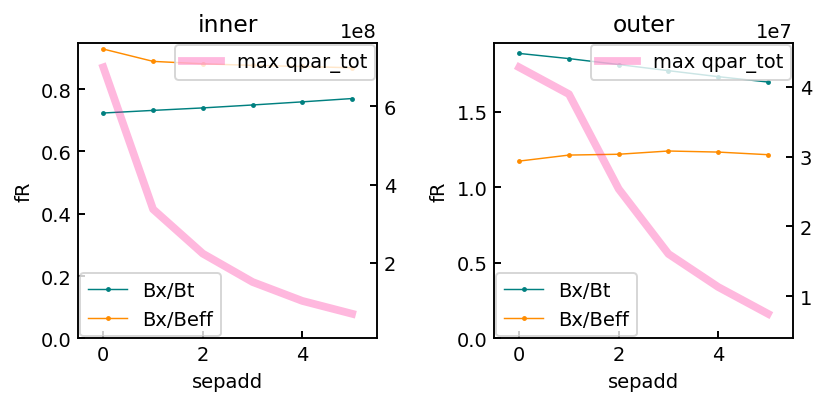

In [46]:
fig, axes = plt.subplots(1,2, figsize = (6,3))

for i, side in enumerate(["inner", "outer"]):
    ax = axes[i]
    df = results[side]
    ax.plot(df.index, df["fR"], label = "Bx/Bt", **line_style)
    ax.plot(df.index, df["fR_eff"], label = "Bx/Beff", **line_style)
    ax2 = ax.twinx()
    ax2.plot(df.index, df["qmax"], lw = 4, alpha = 0.3, c = "deeppink", label = "max qpar_tot")
    ax.set_title(side)
    ax.set_xlabel("sepadd")
    ax.set_ylabel("fR")
    ax.legend()
    ax2.legend()
    ax.set_ylim(0, None)
    
fig.tight_layout()

In [42]:
for side in ["inner", "outer"]:
    df = results[side]
    ratio = df["fR_eff"] / df["fR"]
    weighted_ratio = ((df["qmax"] * ratio) / df["qmax"].sum()).sum()
    qpar_avg_fR = (df["fR"] * df["qmax"] / df["qmax"].sum()).sum()
    qpar_avg_fR_eff = qpar_avg_fR * weighted_ratio
    
    print(side)
    # print(f"Weighted ratio: {weighted_ratio:.2f}")
    print(f"qpar_avg_fR: {qpar_avg_fR:.2f}")
    print(f"qpar_avg_fR_eff: {qpar_avg_fR_eff:.2f}")
    
    
results["outer"]
# avg_fR = df[]


inner
qpar_avg_fR: 0.73
qpar_avg_fR_eff: 0.90
outer
qpar_avg_fR: 1.83
qpar_avg_fR_eff: 1.21


,qmax,Beff,Bt,Bx,fR,fR_eff
0,4.275898e+07,2.913048,1.812608,3.419193,1.886339,1.173751
1,3.891800e+07,2.766126,1.812409,3.356813,1.852127,1.213543
2,2.535727e+07,2.694568,1.812058,3.284797,1.812744,1.219044
3,1.606757e+07,2.588307,1.811684,3.210717,1.772228,1.240470
4,1.133387e+07,2.544560,1.811424,3.138381,1.732550,1.233369
5,7.505071e+06,2.527927,1.811450,3.074117,1.697047,1.216063


In [ ]:
case = '100MW_inner_arpuff'
# case = '100MW_innerar_midplanepuff'
# region = "outer_upper"
region = "inner_upper"

fig, ax = plt.subplots()
df = slc.get_1d_radial_data(["fhex_total", "fhex_cond"], region = "omp", keep_geometry = True, guards = False)
df["hf_tot"] = df["fhex_total"] / df["apar"] * -1
df["hf_cond_e"] = df["fhex_cond"] / df["apar"] * -1

omp_hflux = df.copy()
omp_hflux = omp_hflux[omp_hflux["dist"] > 0].reset_index(drop = True)
df_weighted = pd.DataFrame()

for i in range(sepadds):
    df = dfs[case][region][i]
    dfx = df[df["Xpoint"]==1]
    df_weighted[i] = df["RAr"] 
    ax.plot(df["Spar"], df["cumR"], color = colors[i], **line_style,  label = f"SOL ring {i+1}") 
    ax.plot(dfx["Spar"], dfx["cumR"], color = colors[i], **xpoint_style) 
    
df_weighted = pd.DataFrame(df_weighted.mean(axis = 1), columns = ["RAr"])
cumR = sp.integrate.cumulative_trapezoid(y = df_weighted["RAr"] / df["Btot"], x = df["Spar"], initial = 0)
df_weighted["cumR"] = cumR/cumR[-1]
ax.plot(df["Spar"], df_weighted["cumR"], color = "darkslategrey", lw = 3, alpha = 0.5, ls = "-", label = "Average")

ylims = ax.get_ylim()
ax.set_ylim(ylims)
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("$\int{Q_{Ar}}\ ds_{\parallel}$ (normalised)")

if case in labels.keys():
    name = labels[case]
else:
    name = case
    
ax.set_title(f"Cumulative argon radiation: {name}, {region}")
ax.set_ylabel("Te [eV]")
ax.legend(fontsize = "x-small")